In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wisps
from astropy.io import ascii
from scipy.optimize import curve_fit
from scipy import interpolate
from tqdm import tqdm
%matplotlib inline

In [2]:
spec=ascii.read('orion_spectrum.dat').to_pandas()
spec.columns=['wave', 'flux']

In [3]:
#normalize 
spec['flux']= spec.flux/np.nanmax(spec.flux)

In [4]:
spec=spec.dropna()

In [5]:
def fit_continuum():
    ##fit a continuum to the spec
    #do a sigma clip to reduce 
    flux=spec.flux.values
    sigma=np.nanstd(flux)
    print (sigma)
    mask=abs(flux) < 0.1*abs(sigma)
    f=flux[mask]
    w=spec.wave.values[mask]
    pol=np.polyfit(w, f, 4)
    return w, f, np.poly1d(pol)
#Gaussian function
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def fit_a_gaussian(x, y, center0, std0):
    
    popt, pcov = curve_fit(gauss_function, x, y, p0 = [1, center0, std0])
    return  popt, pcov

def get_slice(wvrng):
    mask=spec.wave.between(wvrng[0], wvrng[1])
    return spec.wave[mask].values, spec.flux[mask].values


In [6]:
sx, sy, cont_f=fit_continuum()

0.03074758485900112


In [7]:
spec['flux']= spec.flux/np.nanmax(spec.flux)

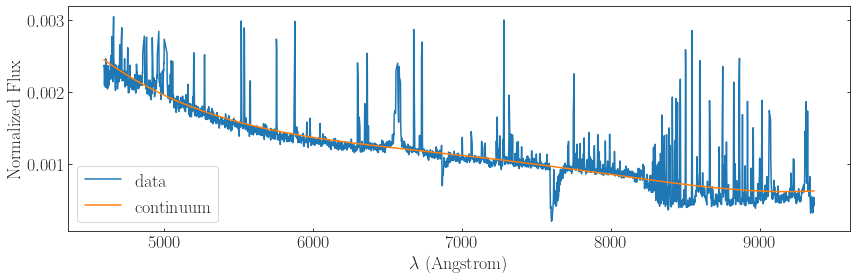

In [8]:
fig, ax=plt.subplots(figsize=(12, 4))
plt.plot(sx, sy, label='data')
plt.plot(sx, cont_f(sx), label='continuum')

ax.set_ylabel('Normalized Flux', fontsize=18)
ax.set_xlabel(r'$\lambda$ (Angstrom) ', fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('continuum_fit.pdf')

In [9]:
def  measure_line_ratio(x1, x2, **kwargs):
    #create a grid
    w1grid=np.linspace(x1[0], x1[-1], 1000)
    w2grid=np.linspace(x2[0], x2[-1], 1000)
    
    #fit a gaussian
    w1, f1=get_slice(x1)
    line1, err1=fit_a_gaussian(w1, f1, np.nanmedian(x1), np.nanstd(x1))
    
    w2, f2=get_slice(x2)
    line2, err2=fit_a_gaussian(w2, f2, np.nanmedian(x2),  np.nanstd(x1))
    
    #get the continuum and flux grid
    fc1=cont_f(w1grid)
    fc2=cont_f(w2grid)
    
    
    #gaussian flux from interpolation
    g1=gauss_function(w1grid, line1[0], line1[1], line1[2])
    g2=gauss_function(w2grid, line2[0], line2[1], line2[2])
    
    #do the intergal
    ew1= np.trapz(g1/fc1, x=w1grid)
    ew2=np.trapz(g2/fc2, x=w2grid)
    
    
    print ('best fit gaussians center line 1 {} std {} EW {}'.format(line1[1], line1[2], ew1))
    print ('best fit gaussians center line 2 {} std {} EW {}'.format(line2[1], line2[2], ew2))
    print ('line ratio {}'.format(ew1/ew2))
    
    #big data
    big_datax,  big_datay =get_slice([np.concatenate([x1, x2]).min(), np.concatenate([x1, x2]).max()])
    big_cont=cont_f(big_datax)
    
    if kwargs.get('plot', False):
        ax=kwargs.get('ax',plt.gca())
        fname=kwargs.get('fname', 'random.pdf' )

        ax.plot(big_datax,  big_datay, '-o', label='data', c='k')
        ax.plot( big_datax,  big_cont, label='continuum', c='b')
   
        
        ax.plot(w1grid, g1, label='Gaussian fit', c='g')
        ax.plot(w2grid, g2, c='g')
        
        plt.minorticks_on()
        plt.legend(fontsize=18)
        ax.set_ylabel('Normalized Flux', fontsize=18)
        ax.set_xlabel(r'$\lambda$ (Angstrom) ', fontsize=18)
        plt.tight_layout()
        plt.savefig(fname)
    
    return 


best fit gaussians center line 1 4713.134921114331 std 4.169117985565382 EW 11.904802894479843
best fit gaussians center line 2 4733.153041780109 std 44.022511428334965 EW 14.961716997650107
line ratio 0.7956842718218514


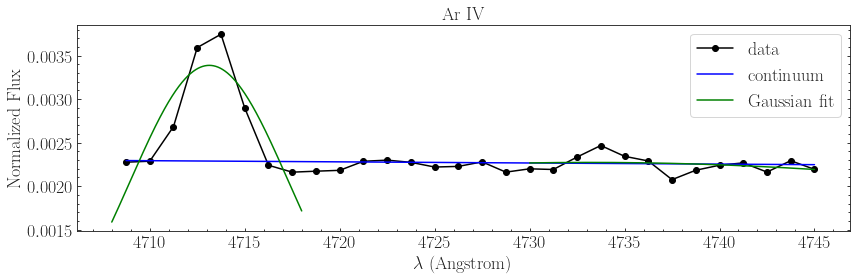

In [10]:
fig, ax=plt.subplots(figsize=(12,4))
plt.title('Ar IV', fontsize=18)
plt.minorticks_on()
measure_line_ratio([4708, 4718],[4730, 4745], fname='argon_line.pdf', plot=True)

best fit gaussians center line 1 6716.880805551045 std 1.1499794328242694 EW 49.26811918959927
best fit gaussians center line 2 6731.293740807327 std 1.1366562256223856 EW 72.09265467193111
line ratio 0.683399985945885


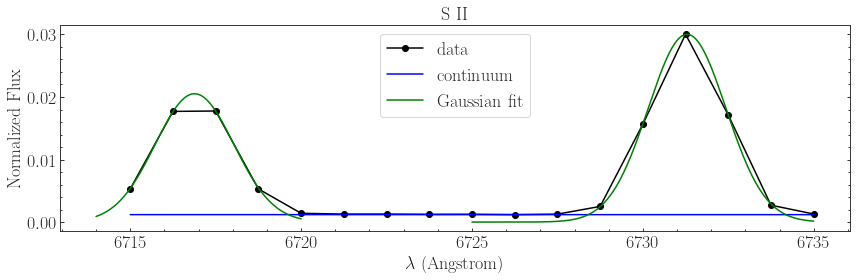

In [11]:
fig, ax=plt.subplots(figsize=(12,4))
plt.title('S II', fontsize=18)
plt.minorticks_on()
measure_line_ratio([6714, 6720], [6725, 6735],  fname='sulfur_lines.pdf', plot=True)

best fit gaussians center line 1 5754.832516866377 std 7.929178832532492 EW 23.71071350413377
best fit gaussians center line 2 6548.415871666446 std -1.0992803955424948 EW 151.79417352442434
line ratio 0.1562030541331589


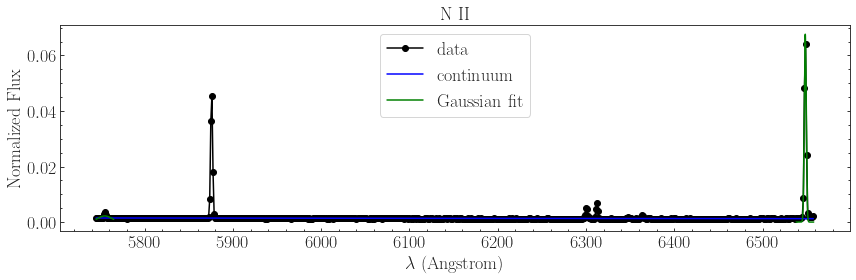

In [12]:
fig, ax=plt.subplots(figsize=(12,4))
plt.title('N II', fontsize=18)
measure_line_ratio([ 5755-10, 5755+10], [6548-10, 6548+10],  fname='nitrogen_lines.pdf', plot=True)

In [13]:
#fig, ax=plt.subplots(figsize=(12,4))
#plt.title(' I', fontsize=18)
#measure_line_ratio([  5577-10,  5577+10], [6302-10, 6302+10],  fname='oxygen_lines.pdf', plot=True)

In [14]:
import pyneb as pn
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [30]:
#create a class with a list of diagnostic lines and the measurements

diags = pn.Diagnostics() 
diags.addDiag(['[NII] 5755/6548', '[ArIV] 4740/4711', '[SII] 6731/6716' ])


In [31]:
diags.getCrossTemDen('[NII] 5755/6548', '[SII] 6731/6716', '[ArIV] 4740/4711', 0.15, 1.47, 0.7 )

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [19]:
diags.diags

{'[NII] 5755/6548': ('N2', 'L(5755)/L(6548)', 'RMS([E(6548), E(5755)])'),
 '[ArIV] 4740/4711': ('Ar4', 'L(4740)/L(4711)', 'RMS([E(4711), E(4740)])'),
 '[SII] 6731/6716': ('S2', 'L(6731)/L(6716)', 'RMS([E(6716), E(6731)])')}

In [20]:
N2_EG = pn.EmisGrid(elem='N', spec=2, n_tem=100, n_den=100, 
                    tem_min=5000., tem_max=20000., den_min=10., 
                    den_max=1.e8, restore_file=None, atomObj=None)

In [21]:
N2_Te = N2_EG.getGrid(to_eval = 'L(5755)/L(6548)')

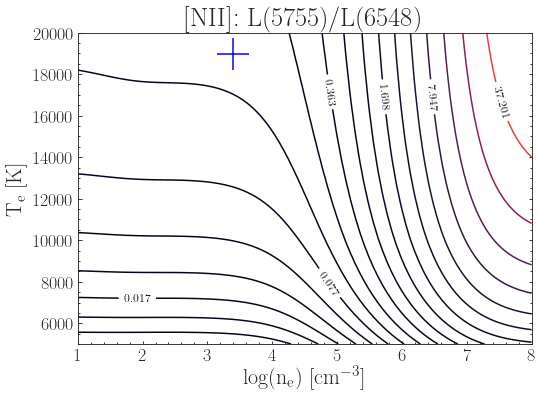

In [22]:
fig, ax=plt.subplots(figsize=(8, 6))
N2_EG.plotContours(to_eval = 'L(5755)/L(6548)', ax=ax, log_levels=False)
ax.scatter( np.log10(2488), 18953,s=1000, marker='+', c='b')
plt.tight_layout()
plt.minorticks_on()
plt.savefig('temperature_contours.pdf')

In [41]:
import astropy.units as u

In [43]:
160*u.arcsec.to(u.radian)*440

0.3413088315011133